# 続・detectron2 for まちカドまぞく ～カスタム・トランスフォーム編～

<img src="https://user-images.githubusercontent.com/33882378/79108777-0634dd80-7db2-11ea-9196-da78e336c13d.jpg">

標準以外の水増しを行う方法

いろいろしたい場合は自分で書く必要があります。

* 2020/04/17 カットアウトを加えてみました。

---

In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import random

In [2]:
# VoTT のエクスポートファイルや、画像が格納されているディレクトリ
BASE_DIRECTORY = './vott-json-export/'
# VoTT のエクスポートファイル名
EXPORT_FILENAME = 'Machikado-export.json'
# 訓練データに使用する割合
TRAIN_RATIO = 0.8
# 乱数シード
RANDOM_STATE = 0

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from machikado_util.Machikado_vott import get_cat_names, get_machikado_dicts

# vott エクスポートファイルの読み込み
CAT_NAME2ID, CAT_ID2NAME = get_cat_names(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME))
dataset_dicts = get_machikado_dicts(os.path.join(BASE_DIRECTORY, EXPORT_FILENAME), BASE_DIRECTORY, CAT_NAME2ID)

警告: name: 59.jpg - 画像サイズが不一致であるためスキップ image_size:(268, 201), ./vott-json-export/Machikado-export.json: (600, 600)


---

## カスタムトランスフォーム

> detectron2/data/transforms/transform.py を参考にして書いた

### せん断変形

* いろいろな水増しがあると思うのですが、せん断変形を作ってみました。
* 画像は numpy で来るので、cv2 の機能で変形してもよいですし、いったん torch.tensor にして変形したのち、numpy に変換し直しても良いようです。
<p>torch を使用している例もあったが、めんどくさいのでやめにしました。（早くなるのだろうか？）</p>
* あと、セグメンテーションの領域データも変形する必要があります。

> * apply_coords とか apply_polygons の部分ですが、変形後ポリゴンが分断されたり、無くなってしまったりすることがありますので、
フォローが必要ならば気をつけるべきです。
>
> * 標準のクロッピングは、領域のセンターが画面からはみ出さないようにしていますので、このあたりを参考にしたら良いかと思います。
今回カスタムしたものには何もしていませんが・・・

In [4]:
import shapely.geometry as geometry
from fvcore.transforms.transform import Transform

class ShearTransform(Transform):
    def __init__(self, h, w, angle_h, angle_v):
        super().__init__()
        self._set_attributes(locals())
        
        self.mat = np.array([[1, np.tan(np.deg2rad(angle_h)), 0],
                             [np.tan(np.deg2rad(angle_v)), 1, 0]])
        
    def apply_image(self, img: np.ndarray):
        assert len(img.shape) == 3, '3ch のカラー画像のみを対象とする'
        h, w = img.shape[:2]
        assert (self.h == h and self.w == w), '画像サイズ不整合 h:w {}:{} -> {}:{}'.format(self.h, self.w, h, w)
        
        return cv2.warpAffine(img, self.mat, (w, h))

    def apply_coords(self, coords: np.ndarray):
        p = np.vstack([coords.T, np.ones((1, len(coords)))])
        p = np.dot(self.mat, p)
        
        return p.T

    def apply_polygons(self, polygons):
        polygons = [self.apply_coords(p) for p in polygons]

        # 画像範囲でクリッピング
        crop_box = geometry.box(0, 0, self.w, self.h).buffer(0)
        
        cropped_polygons = []
        
        for polygon in polygons:
            polygon = geometry.Polygon(polygon).buffer(0)
            assert polygon.is_valid, '不正なポリゴン {}'.format(polygon)
            
            cropped = polygon.intersection(crop_box)
            
            if cropped.is_empty:
                continue
            
            # 複数のポリゴンに分割される可能性があるのでその処理が必要
            if not isinstance(cropped, geometry.collection.BaseMultipartGeometry):  # 単一であればリストに
                cropped = [cropped]
            
            for poly in cropped:
                if not isinstance(poly, geometry.Polygon) or not poly.is_valid:  # 不正なポリンゴンを無視する
                    continue
                
                coords = np.asarray(poly.exterior.coords)
                cropped_polygons.append(coords[:-1])  # ポリゴンの終端が先端になっているので終端を削除
        
        assert len(cropped_polygons) > 0, 'せん断変形の結果、有効な領域が残らなかった'
        
        return cropped_polygons

### ジェネレータも用意しておくと標準との統一感が出る

> detectron2/data/transforms/transform_gen.py を参考にして書いた

トランスフォーム ShearTransform を生成するものです。毎回ランダムなんで作り置きが出来ないんですね。

In [5]:
from detectron2.data import transforms as T

class RandomShear(T.TransformGen):
    def __init__(self, angle_h_range, angle_v_range):
        super().__init__()
        self._init(locals())

    def get_transform(self, img):
        h, w = img.shape[:2]
        
        if self.angle_h_range is None:
            angle_h = 0
        else:
            angle_h = np.random.uniform(self.angle_h_range[0], self.angle_h_range[1])
            
        if self.angle_v_range is None:
            angle_v = 0
        else:
            angle_v = np.random.uniform(self.angle_v_range[0], self.angle_v_range[1])
       
        return ShearTransform(h, w, angle_h, angle_v)

### カットアウト

* ランダムに円を描画して画像を欠落させます。
* マスクデータに変更を加えるには色々大変そうなので画像のみを対象とします。
* よって、マスクの座標を変更する箇所は必要ありませんが、
fvcore.transforms.transform の apply_coords が `@abstractmethod` となっていますので、何も変形しない処理を記述しておきます。
* マスクに変更を加えたい場合は、マスクデータをポリゴンではなくビットマスクとして与える方法があるようですが試していません。

> * coco RLE 形式でビットマスクを与えるようです。
> <p>dataset_dicts の annotations の segmentation に REL データを設定する。</p>
> * ビットマスクの場合は、apply_segmentation がビットマスクの変形に使用されます。
> <p>detectron2/data/detection_utils.py の transform_instance_annotations。detectron2/data/transforms/transform.py を参照</p>
>
> ~~~
def apply_segmentation(self, segmentation):
    segmentation = self.apply_image(segmentation, interp=cv2.INTER_NEAREST)
    return segmentation
~~~

#### トランスフォームとジェネレータ

In [6]:
class CutoutTransform(Transform):
    def __init__(self, h, w, centers, radii, colors):
        """
        centers: 中心のリスト
        radii: 半径のリスト
        colors: 色のリスト
        """
        super().__init__()
        self._set_attributes(locals())
        
    def apply_image(self, img: np.ndarray):
        assert len(img.shape) == 3, '3ch のカラー画像のみを対象とする'
        h, w = img.shape[:2]
        assert (self.h == h and self.w == w), '画像サイズ不整合 h:w {}:{} -> {}:{}'.format(self.h, self.w, h, w)
        
        assert len(self.centers) == len(self.radii) == len(self.colors), '引数の不整合'
        for pt, r, c in zip(self.centers, self.radii, self.colors):
            img = cv2.circle(img, pt, r, color=c, thickness=-1)
        
        return img
        
    def apply_coords(self, coords: np.ndarray):
        return coords

In [7]:
class RandomCutout(T.TransformGen):
    def __init__(self, num_hole_range, radius_range, color_ranges):
        """
        num_max_hole: 穴数の範囲(min, max)
        radius_range: 半径の範囲(min, max) ※画像の短辺の長さに対する割合で指定
        color_ranges: RGBそれぞれの範囲組み合わせ [Bの範囲(min, max), Gの範囲(min, max), Rの範囲(min, max)]
        """
        super().__init__()
        self._init(locals())

    def get_transform(self, img):
        h, w = img.shape[:2]
        
        short_len = h if h < w else w
        
        num_hole = np.random.randint(self.num_hole_range[0], self.num_hole_range[1])
        centers, radii, colors = [], [], []
        
        for _ in range(num_hole):
            centers += [(int(np.random.uniform(0, h)), int(np.random.uniform(0, w)))]
            radii += [int(short_len * np.random.uniform(self.radius_range[0], self.radius_range[1]))]

            g = np.random.uniform(self.color_ranges[0][0], self.color_ranges[0][1])
            b = np.random.uniform(self.color_ranges[1][0], self.color_ranges[1][1])
            r = np.random.uniform(self.color_ranges[2][0], self.color_ranges[2][1])
            colors += [(int(g), int(b), int(r))]
       
        return CutoutTransform(h, w, centers, radii, colors)

---
## 学習

### カスタムデータマッパー

カスタムした変形を加えています。

In [8]:
import copy
import logging
import torch

from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils

class MachikadoDatasetMapper:
    def __init__(self, cfg, is_train=True):
        assert cfg.MODEL.MASK_ON, '今回はセグメンテーションのみを対象にする'
        assert not cfg.MODEL.KEYPOINT_ON, 'キーポイントは扱わない'
        assert not cfg.MODEL.LOAD_PROPOSALS, 'pre-computed proposals っていうのがよくわからん・・・・とりあえず無効前提で'
        
        self.cont_gen = None
        if cfg.INPUT.CONTRAST.ENABLED:
            self.cont_gen = T.RandomContrast(cfg.INPUT.CONTRAST.RANGE[0], cfg.INPUT.CONTRAST.RANGE[1])
            
        self.bright_gen = None
        if cfg.INPUT.BRIGHTNESS.ENABLED:
            self.bright_gen = T.RandomBrightness(cfg.INPUT.BRIGHTNESS.RANGE[0], cfg.INPUT.BRIGHTNESS.RANGE[1])
            
        self.extent_gen = None
        if cfg.INPUT.EXTENT.ENABLED:
            self.extent_gen = T.RandomExtent(scale_range=(1, 1), shift_range=cfg.INPUT.EXTENT.SHIFT_RANGE)
            
        self.crop_gen = None
        if cfg.INPUT.CROP.ENABLED:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info('CropGen used in training: ' + str(self.crop_gen))
        
        self.rotate_gen = None
        if cfg.INPUT.ROTATE.ENABLED:
            self.rotate_gen = T.RandomRotation(cfg.INPUT.ROTATE.ANGLE, expand=False)
        
        # ここに追加した！
        self.shear_gen = None
        if cfg.INPUT.SHEAR.ENABLED:
            self.shear_gen = RandomShear(cfg.INPUT.SHEAR.ANGLE_H_RANGE, cfg.INPUT.SHEAR.ANGLE_V_RANGE)
        
        self.cutout_gen = None
        if cfg.INPUT.CUTOUT.ENABLED:
            self.cutout_gen = RandomCutout(cfg.INPUT.CUTOUT.NUM_HOLE_RANGE, cfg.INPUT.CUTOUT.RADIUS_RANGE, cfg.INPUT.CUTOUT.COLOR_RANGE)
            
        self.tfm_gens = utils.build_transform_gen(cfg, is_train)
        
        self.img_format = cfg.INPUT.FORMAT
        self.mask_format = cfg.INPUT.MASK_FORMAT
        self.is_train = is_train

    def __call__(self, dataset_dict):
        assert 'annotations' in dataset_dict, '今回はセグメンテーションのみを対象にする'
        assert not 'sem_seg_file_name' in dataset_dict, 'パノプティックセグメンテーションは行わない'
        
        dataset_dict = copy.deepcopy(dataset_dict)
        
        image = utils.read_image(dataset_dict['file_name'], format=self.img_format)
        utils.check_image_size(dataset_dict, image)
        
        # テストの場合はアノテーションがいらないので削除して終了
        if not self.is_train:
            dataset_dict.pop('annotations', None)
            dataset_dict.pop('sem_seg_file_name', None)
            return dataset_dict
        
        # 画像のみを変換
        # 明るさ・コントラスト
        if self.cont_gen is not None:
            tfm = self.cont_gen.get_transform(image)
            image = tfm.apply_image(image)
        if self.bright_gen is not None:
            tfm = self.bright_gen.get_transform(image)
            image = tfm.apply_image(image)
        # ここに追加した！
        if self.cutout_gen is not None:
            tfm = self.cutout_gen.get_transform(image)
            image = tfm.apply_image(image)
            
        # アフィン
        if self.rotate_gen is not None:
            rotate_tfm = self.rotate_gen.get_transform(image)
            image = rotate_tfm.apply_image(image)
        # ここに追加した！
        if self.shear_gen is not None:
            shear_tfm = self.shear_gen.get_transform(image)
            image = shear_tfm.apply_image(image)
        if self.extent_gen is not None:
            extent_tfm = self.extent_gen.get_transform(image)
            image = extent_tfm.apply_image(image)
        if self.crop_gen is not None:
            crop_tfm = utils.gen_crop_transform_with_instance(
                self.crop_gen.get_crop_size(image.shape[:2]), image.shape[:2], np.random.choice(dataset_dict['annotations']))
            image = crop_tfm.apply_image(image)
        
        # transforms に登録していく順番に注意！（上の画像変換と順番を揃えること）
        image, transforms = T.apply_transform_gens(self.tfm_gens, image)
        
        if self.crop_gen is not None:
            transforms = crop_tfm + transforms
        if self.extent_gen is not None:
            transforms = extent_tfm + transforms
        # ここに追加した！
        if self.shear_gen is not None:
            transforms = shear_tfm + transforms
        if self.rotate_gen is not None:
            transforms = rotate_tfm + transforms

        image_shape = image.shape[:2]  # h, w
        dataset_dict['image'] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        # ここで画像データが変形される（変形順番は上で追加した順番になるので注意）
        annos = [utils.transform_instance_annotations(obj, transforms, image_shape, keypoint_hflip_indices=None)
                 for obj in dataset_dict.pop('annotations')
                 if obj.get("iscrowd", 0) == 0]

        instances = utils.annotations_to_instances(annos, image_shape, mask_format=self.mask_format)

        # マスクからバウンディングボックスを修正
        if self.crop_gen and instances.has("gt_masks"):
            instances.gt_boxes = instances.gt_masks.get_bounding_boxes()

        dataset_dict["instances"] = utils.filter_empty_instances(instances)

        return dataset_dict

### カスタマイズした設定

* カスタムした分を追加しています。

In [9]:
from detectron2.config import CfgNode as CN

# カスタムした分の設定を追加する
def append_custom_cfg(cfg):
    cfg.INPUT.ROTATE = CN()
    cfg.INPUT.CONTRAST = CN()
    cfg.INPUT.BRIGHTNESS = CN()
    cfg.INPUT.EXTENT = CN()
    
    cfg.INPUT.SHEAR = CN()  # 追加
    cfg.INPUT.CUTOUT = CN()  # 追加

    cfg.INPUT.ROTATE.ENABLED = True
    cfg.INPUT.ROTATE.ANGLE = [-20, 20]
    cfg.INPUT.CONTRAST.ENABLED = True
    cfg.INPUT.CONTRAST.RANGE = (0.5, 1.5)
    cfg.INPUT.BRIGHTNESS.ENABLED = True
    cfg.INPUT.BRIGHTNESS.RANGE = (0.8, 1.2)
    cfg.INPUT.EXTENT.ENABLED = True
    cfg.INPUT.EXTENT.SHIFT_RANGE = (0.2, 0.2)
    
    cfg.INPUT.SHEAR.ENABLED = True  # 追加
    cfg.INPUT.SHEAR.ANGLE_H_RANGE = (-10, 10)  # 追加
    cfg.INPUT.SHEAR.ANGLE_V_RANGE = (-5, 5)  # 追加
    
    cfg.INPUT.CUTOUT.ENABLED = True  # 追加
    cfg.INPUT.CUTOUT.NUM_HOLE_RANGE = (5, 20)  # 追加
    cfg.INPUT.CUTOUT.RADIUS_RANGE = (0.05, 0.15)  # 追加
    cfg.INPUT.CUTOUT.COLOR_RANGE = ([0, 255], [0, 255], [0, 255])  # 追加

In [10]:
from detectron2.config import get_cfg

cfg = get_cfg()
append_custom_cfg(cfg)

cfg.MODEL.MASK_ON = True

cfg.INPUT.MIN_SIZE_TRAIN = 400
cfg.INPUT.MAX_SIZE_TRAIN = 640
cfg.INPUT.MIN_SIZE_TEST = 400
cfg.INPUT.MAX_SIZE_TEST = 640

cfg.INPUT.CROP.ENABLED = False
cfg.INPUT.CROP.SIZE = [0.8, 0.8]

cfg.INPUT.ROTATE.ENABLED = False
cfg.INPUT.EXTENT.ENABLED = False
# cfg.INPUT.SHEAR.ENABLED = False
# cfg.INPUT.CUTOUT.ENABLED = False

---
### テスト表示

心霊写真のオーブみたいな感じですなぁ・・・ｗ

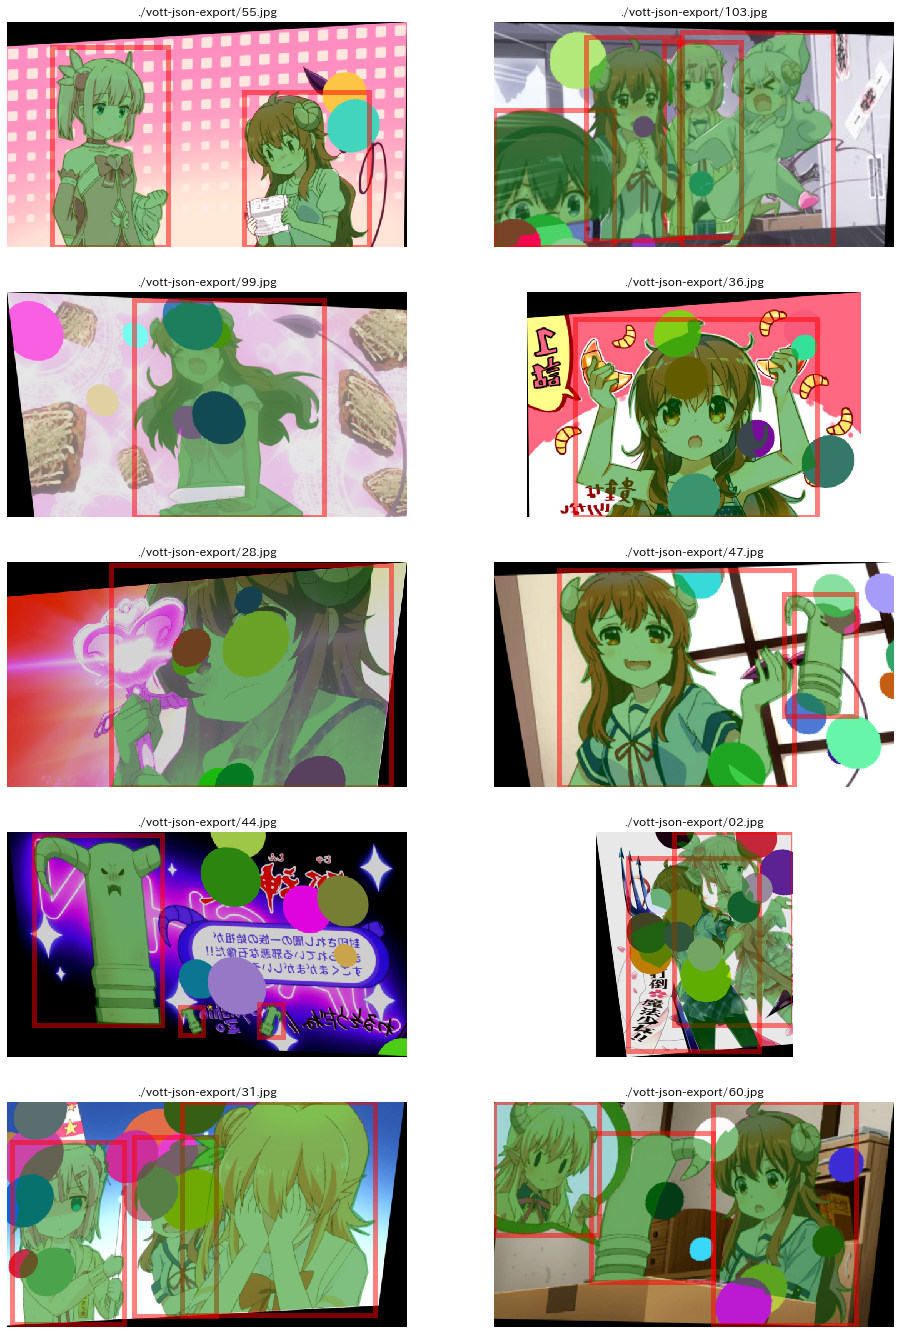

In [11]:
from machikado_util.plot_dataset_mapper import plot_dataset_mapper

# random.seed(RANDOM_STATE)
mapper = MachikadoDatasetMapper(cfg, is_train=True)
plot_dataset_mapper(dataset_dicts, mapper)